In [1]:
from interval import interval
import torch
from interval_tensor import *
import numpy as np
from matplotlib import pyplot as plt

In [15]:
import math

def linear(x1, x2 ):
    return x1*x2


def fun(x):
    return torch.sigmoid(x)

def funs(x):
    return sigmoid_interval(x)

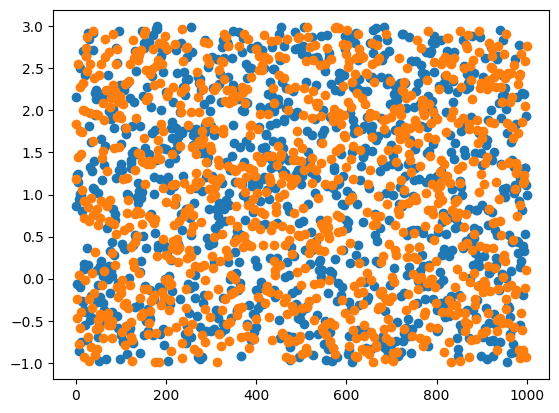

In [21]:
samples = 1000

t1 = torch.distributions.uniform.Uniform(-1, 3).sample([samples])
t2 = torch.distributions.uniform.Uniform(-1, 3).sample([samples])

it1 = interval([-1, 3])
it2 = interval([-1, 3])

xs = torch.zeros(samples)
sp = torch.linspace(0,samples,samples)

ft = linear(t1,t2)
fit = linear(it1,it2)


#plt.scatter(ft, xs, s=0.5, marker=".")
#plt.scatter( [fit[0][0], fit[0][1]] , [0,0], marker="*" );

plt.scatter(sp, t1)
plt.scatter(sp, t2)

In [ ]:
-2*interval([4,5])+3*interval([4,5]), 1*interval([4,5]), 